# Colocalization

Colocalization refers to two distinct measures: co-occurance and correlation [https://jcs.biologists.org/content/131/3/jcs211847].




## Co-occurance

In this context, we tried to evaluate the overlap of the set of pixels between two images.

We start by creating a pair of test images. The images are composed of circles of which a fraction is overlapping.


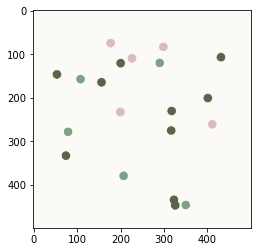

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

def create_images(n,m,r0,rho):
    ''' 
    Create a test image with random circles 
    n : image size
    m : total number of circle
    r0 : radius of circles
    rho : proportion of overlapping circle
    output:
    '''
    np.random.seed()
    x,y = np.meshgrid(range(n), range(n))
    p = 0.1+0.8*np.random.rand(3,m)
    S = np.array([[n,0,0],[0,n,0],[0,0,0]])
    p = np.matmul(S,p)
    p[2,:] = p[2,:] + r0
    I1 = np.zeros((n,n))
    I2 = np.zeros((n,n))
    n1 = 0
    n2 = 0
    n12 = 0
    for i in range(m):
        v = np.random.rand()
        D = ((x - p[0,i]) / p[2,i])**2 + ((y-p[1,i]) / p[2,i])**2 < 1
        if v < 0.5 + rho/2:
            I1 = np.logical_or(I1 , D)
            n1 = n1 + 1
        if  v > 0.5 - rho/2:
            I2 = np.logical_or(I2 , D)
            n2 = n2 + 1
        if v >0.5 - rho/2 and v < 0.5 + rho/2:
            n12 = n12 + 1
    return I1,I2 
    
im1,im2 = create_images(500,20,10,0.5)

plt.imshow(im1,cmap='Reds',alpha=0.5)
plt.imshow(im2,cmap='Greens',alpha=0.5)

Let's define another way to image pair:

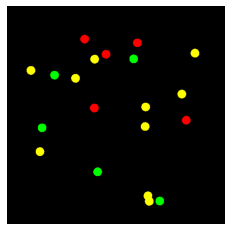

In [2]:
def to_rgb(im1,im2):
    ''' Convert the a2 channel image to a xyc rgb image'''
    shp = (im1.shape[0],im1.shape[1],3)
    rgb = np.zeros(shp,dtype=im1.dtype)
    rgb[:,:,0] = im1
    rgb[:,:,1] = im2
    return rgb
    
# Another way to display the image pair:
plt.imshow(to_rgb(im1,im2).astype('f'))
plt.axis('off')
plt.show()

### Manders coefficients

To evaluate co-occurance we compute the Manders coefficients defined by the ratios M1 = (A . B) / (A) and M2 = (A . B) / B. The regions A and B will be defined by segmenting each channels.

Manders, E., Verbeek, F. and Aten, J. (1993) Measurement of co‐localization of objects in dual‐colour confocal images. Journal of Microscopy, 169, Pt 3, 375–382. 

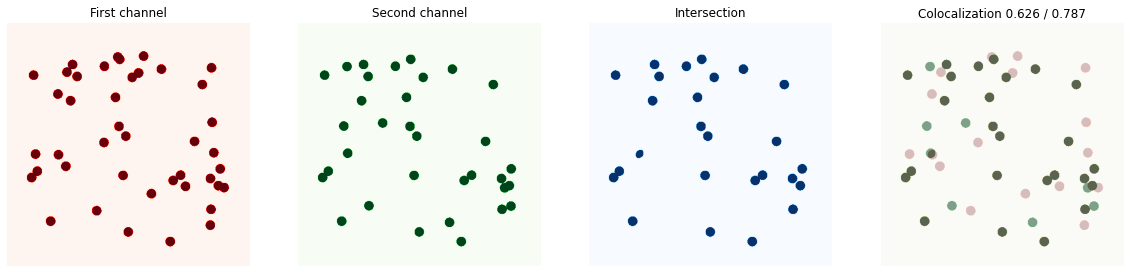

In [3]:
# Let's define a function for computing the Manders coefficients
def manders_coefficients(im1,im2,display=False):
    ''' Compute Manders overlap coefficients'''
    intersect = np.logical_and(im1,im2)
    p12 = np.sum(intersect>0)
    p1 = np.sum(im1>0)
    p2 = np.sum(im2>0)
    if display:
        fig, ax = plt.subplots(1, 4,figsize=(20,7))
        ax[0].imshow(im1,cmap='Reds')
        ax[0].set_title('First channel')
        ax[1].imshow(im2,cmap='Greens')
        ax[1].set_title('Second channel')
        ax[2].imshow(intersect,cmap='Blues')
        ax[2].set_title('Intersection')
        ax[3].imshow(im1,cmap='Reds',alpha=0.5)
        ax[3].imshow(im2,cmap='Greens',alpha=0.5)
        ax[3].set_title(f'Colocalization {p12/p1:.3f} / {p12/p2:.3f}')
        for a in ax:
            a.set_axis_off()
    return ( p12 / p1, p12 / p2)

im1,im2 = create_images(500,50,10,0.5)
M1,M2 = manders_coefficients(im1,im2,True)


1.0000000000000002


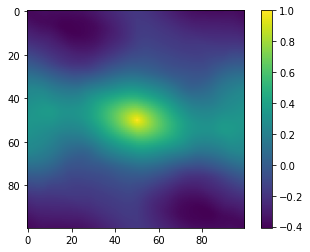

In [4]:
def normxcorr(template,image):
    '''
        Normalized cross correlation
    '''
    from math import sqrt
    template = template - np.mean(template)
    image = image - np.mean(image)
    F = np.fft.fftn(image)
    T = np.fft.fftn(template)
    out = np.real(np.fft.ifftn(F * np.conj(T)))
    F2 = np.fft.fftn(np.square(image))
    A1 = np.fft.fftn(np.ones(template.shape))
    image = np.real(np.fft.fftn(F2*A1)) - np.square(np.real(np.fft.fftn(F*A1)))/np.prod(template.shape)
    image[np.where(image < 0)] = 0
    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)
    out[np.where(np.logical_not(np.isfinite(out)))] = 0
    return np.fft.fftshift(out) * sqrt(np.prod(image.shape))

im1,im2 = create_images(100, 10, 20, 1)
#im1 = im1 + 0.1*np.random.random_sample(im1.shape)
#im2 = im2 + 0.1*np.random.random_sample(im2.shape)
#im2 = np.roll(im2,10)
C = normxcorr(im1,im2)
print(np.max(C))
plt.imshow(C)
plt.colorbar()


## GcoPS

Two binary images can be seen as two random sets for which we would like to test the independance from a probabilitic point of view.
This idea, proposed in  https://onlinelibrary.wiley.com/doi/full/10.1111/biom.13115, is to test the independance of the probability of belonging to each set $p_1$ and $p_2$ and to belong to both sets $p_{12}$ and test their independance by looking at the value of $D=p_{12}- p_1p_2$ normalized by the autocorrelation of the two set.
$$T  = \sqrt{|R|} \frac{p_{12} - p_1 p_2}{\sqrt{\sum_R C_1 C_2}} $$



Manders M1:0.507, M2:0.660
GCoPS D:0.046, T:4.359, pvalue:0.000 The two sets are not independant (colocalized)


('The two sets are not independant (colocalized)', 1.3075681121632599e-05)

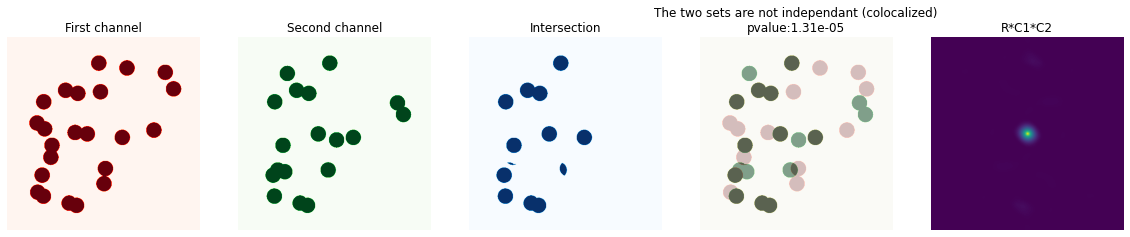

In [5]:
def GcoPS(im1,im2,alpha=0.05,display=False):
    ''' 
    Test the colocalization of two random set 
    https://onlinelibrary.wiley.com/doi/full/10.1111/biom.13115
    '''
    from scipy.stats import norm
    from math import sqrt
    # get the imaeg size
    ny = im1.shape[0]
    nx = im1.shape[1]
    n = nx * ny
    # compute the intersection of the two sets
    intersect = np.logical_and(im1,im2)
    # compute the estimates p1 p2
    p1 = np.mean(im1)
    p2 = np.mean(im2)
    p12 = np.mean(intersect)
    D = p12 - p1 * p2
    # compute the autocorrelation of the two images
    C1 = np.real(np.fft.ifftn(np.abs(np.fft.fftn(im1-p1))**2)) / n
    C2 = np.real(np.fft.ifftn(np.abs(np.fft.fftn(im2-p2))**2)) / n
    # Compute a valid region R where the correlation is above the noise floor 
    R = np.logical_and(C1 > 0.01 * p1*(1-p1), C2 > 0.01 * p2*(1-p2)).astype('f')
    S = np.sum(R * C1 * C2) / np.sum(R)
    # Test statistics
    T = D / sqrt(S)
    # Deduce the pvalue (T is normaly distributed)
    pvalue = 2 * (1-norm.cdf(T))
    # Set the hypothesis message
    if pvalue < alpha:
        msg = 'The two sets are not independant (colocalized)'
    else:
        msg = 'The two sets are independant'
    # Display colocalization information
    if display:
        fig, ax = plt.subplots(1, 5,figsize=(20,7))
        ax[0].imshow(im1,cmap='Reds')
        ax[0].set_title('First channel')
        ax[1].imshow(im2,cmap='Greens')
        ax[1].set_title('Second channel')
        ax[2].imshow(intersect,cmap='Blues')
        ax[2].set_title('Intersection')
        ax[3].imshow(im1,cmap='Reds',alpha=0.5)
        ax[3].imshow(im2,cmap='Greens',alpha=0.5)
        ax[3].set_title(f'{msg}\npvalue:{pvalue:.3g}')
        ax[4].imshow(np.fft.fftshift(R*C1*C2))
        ax[4].set_title('R*C1*C2')
        for a in ax:
            a.set_axis_off()
        print(f'Manders M1:{p12/p1:.3f}, M2:{p12/p2:.3f}')
        print(f'GCoPS D:{D:.3f}, T:{T:.3f}, pvalue:{pvalue:.3f} {msg}')
    return msg, pvalue

im1,im2 = create_images(500,30,20, 0.3)
GcoPS(im1, im2, 0.05, True) 


Test the procedure for various level of colocalization

Text(0.5, 1.0, 'GCOPS')

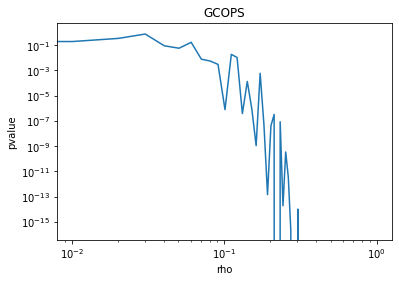

In [13]:
n = 100
p = np.zeros((n,1))
rho = np.linspace(0,1,n)
for i,r in enumerate(rho):
    im1,im2 = create_images(500,100,5, r)
    p[i] = GcoPS(im1, im2, 0.05)[1]

plt.plot(rho,p) 
plt.xlabel('rho')
plt.ylabel('pvalue')
plt.title('GCOPS')


Manders M1:0.037, M2:0.034
GCoPS D:0.000, T:0.129, pvalue:0.898 The two sets are independant
Manders M1:0.065, M2:0.064
GCoPS D:0.001, T:0.689, pvalue:0.491 The two sets are independant


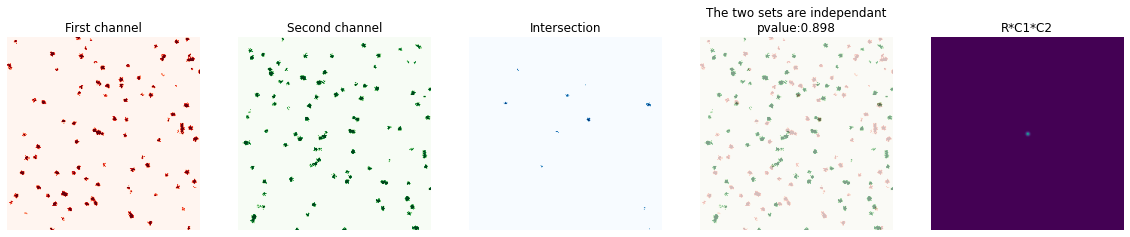

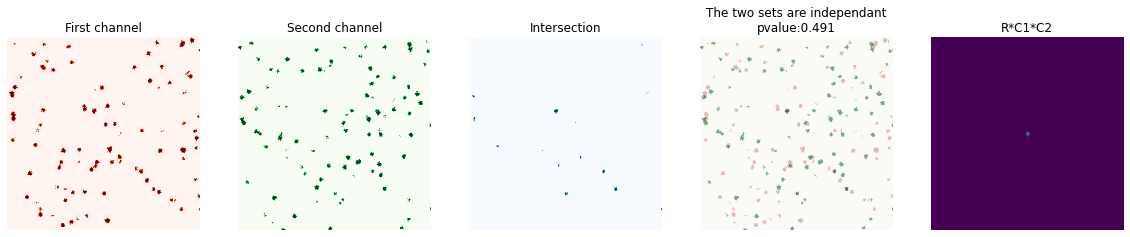

In [12]:
# non colocalized example
im1a = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift1_rho0.png')
im1b = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift2_rho0.png')
msg1, pvalue1 = GcoPS(im1a, im1b, 0.05, True) 

# colocalized example
im2a = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift1_rho05.png')
im2b = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift2_rho05.png')
msg2, pvalue2 = GcoPS(im2a, im2b, 0.05, True) 



## Correlation

The correlation can be estimated using the Pearson correlation coefficient PCC


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Image 2')

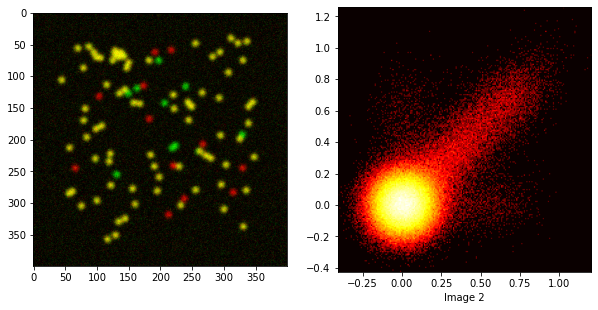

In [16]:
from skimage import filters

def coloc_histogram(im1, im2, height=200, width=200):
    '''
    Colocalization histogram
    https://stackoverflow.com/questions/42639129/is-matplotlib-scatter-plot-slow-for-large-number-of-data
    '''
    im1 = np.ravel(im1)
    im2 = np.ravel(im2)
    xlims = (im1.min(), im1.max())
    ylims = (im2.min(), im2.max())
    dxl = xlims[1] - xlims[0]
    dyl = ylims[1] - ylims[0]
    buffer = np.zeros((height+1, width+1))
    n = np.prod(im1.shape)
    for i in range(n):
        x0 = int(round(((im1[i]- xlims[0]) / dxl) * width))
        y0 = int(round((1 - (im2[i] - ylims[0]) / dyl) * height))
        buffer[y0, x0] += 1
    ax_extent = list(xlims)+list(ylims)
    return ax_extent, buffer

def corrupt_image(img,blur,background,noise_level):
    img = filters.gaussian(img, blur) 
    if backgroud_level > 0:
        bg = np.random.normal(0,backgroud_level,size=img.shape)
        bg = filters.gaussian(bg, img.shape[0]/3)
        img = img + bg
    if noise_level > 0:  
        img = img + np.random.normal(0, noise_level, size=img.shape)
    return img

noise_level = .1
blur = 3
backgroud_level = 0
im1,im2 = create_images(400,100,5, .75)

im1 = corrupt_image(im1, blur, backgroud_level, noise_level)
im2 = corrupt_image(im2, blur, backgroud_level, noise_level)

ax_extent,h = coloc_histogram(im1,im2)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(to_rgb(im1,im2))
ax[1].imshow(np.log(1+h), cmap='hot', extent=ax_extent)
ax[1].set_xlabel('Image 1')
ax[1].set_xlabel('Image 2')


In [17]:
import scipy 
# compute the pearson correlation coefficient
[r,pvalue] = scipy.stats.pearsonr(im1.ravel(), im2.ravel())
print(f'PCC:{r:.2f} pvalue {pvalue:0.3g}')

PCC:0.56 pvalue 0
